<a href="https://colab.research.google.com/github/emichester/07MIAR_Redes_Neuronales_y_Deep_Learning/blob/main/SesionesNotebooks/Sesion_10/07MIAR_VC10_CNN_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07MAIR - Redes Neuronales y Deep Learning
## VC10: Más allá: Visualización e Interpretabilidad

In [1]:
# SOLO PARA USO EN GOOGLE COLABORATORY
# Para conectar el notebook con la cuenta de gdrive
from google.colab import drive
drive.mount('/content/drive/')

# BASE_FOLDER = '/content/drive/My Drive/VIU/07_RN_MIAR/03.Materiales_del_profesor/' # Se debe garantizar que la carpeta docencia compartida se almacena en el directorio raíz de Google Drive. En caso contrario modificar este path

Mounted at /content/drive/


In [2]:
import os
BASE_FOLDER = '/content/drive/MyDrive/ASIGNATURAS/VIU/07MIAR_Redes_Neuronales_y_Deep_Learning/' # Se debe garantizar que la carpeta docencia compartida se almacena en el directorio raíz de Google Drive. En caso contrario modificar este path
RESOURCES_PATH = os.path.join(BASE_FOLDER,"resources")

## **VISUALIZANDO POR DENTRO UNA CNN**

*Visualización vs Interpretación*:
- Visualización se le llama a cuando se analiza sólo el base model.
- Interpretación es cuando además de analizar el base model también se analiza parte del conocimiento del top model.

#### **- Visualizar activaciones intermedias**

- Visualizar el output de las capas de la red
- 2D imagen por canal

In [3]:
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer

# Importando y normalizando el set de datos CIFAR10
print("[INFO]: Loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
labelNames = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camión"]

#One-hot encoding
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

[INFO]: Loading CIFAR-10 data...
170498071/170498071 [==============================] - 3s 0us/step


In [4]:
from keras.models import load_model
model_augmentation = load_model(BASE_FOLDER+'resources/convnet_augmentation.h5')
model_augmentation.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 10, 64)        36928     
                                                      

La primera capa convolucional no usa padding puesto que ya ha perdido dimensiones espaciales (30x30x32) respecto a las de la imagen de entrada (32x32x3). También se puede ver que el stride es de 1 porque no se han reducido a la mitad.

In [5]:
# extraer outputs
from keras import models

output_layers = [layer.output for layer in model_augmentation.layers[:7]] # capas del base model
activation_model = models.Model(inputs=model_augmentation.input, outputs=output_layers)

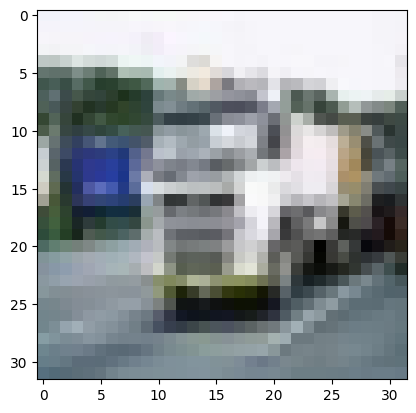

In [25]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img
%matplotlib inline

# Visualizando imagen
sample = 1000
# sample = 600
input_img = trainX[sample].reshape((1,32,32,3))
plt.imshow(array_to_img(trainX[sample]))
plt.show()

In [26]:
# Predecir activaciones
activations = activation_model.predict(input_img)
print(len(activations))

1/1 [==============================] - 0s 45ms/step
7


(1, 30, 30, 32)


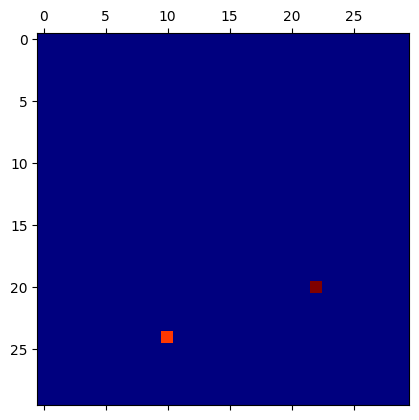

In [27]:
# Activacion, 32 canales, feature map de 30x30
layer = 0
layer_activation = activations[layer]
print(layer_activation.shape)
# Mostrar cualquier canal
channel = 31
plt.matshow(layer_activation[0,:,:,channel], cmap='jet')

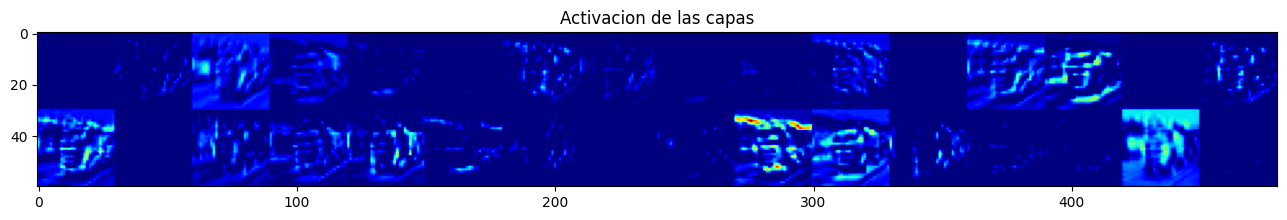

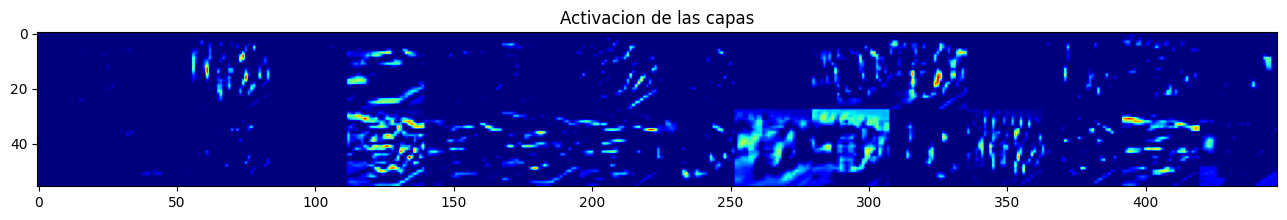

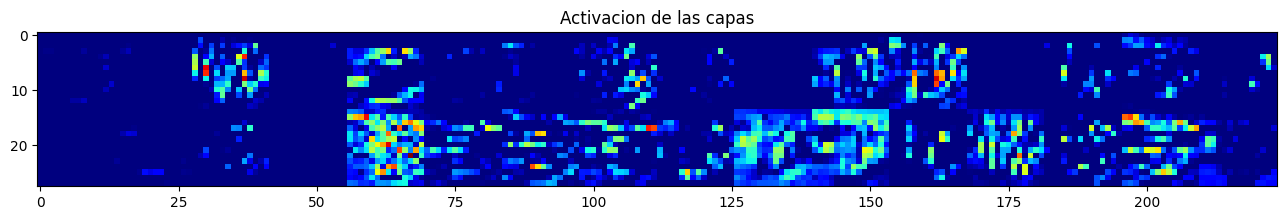

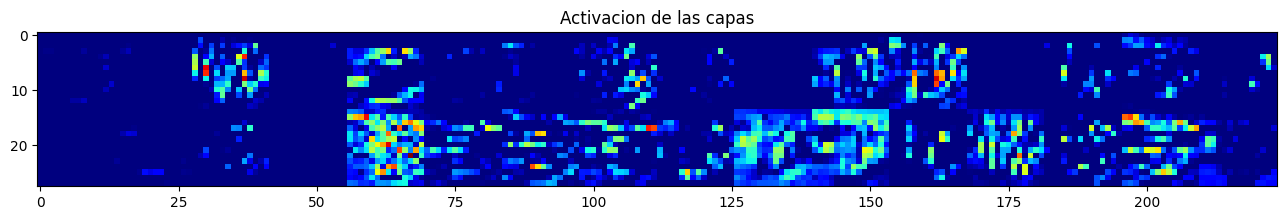

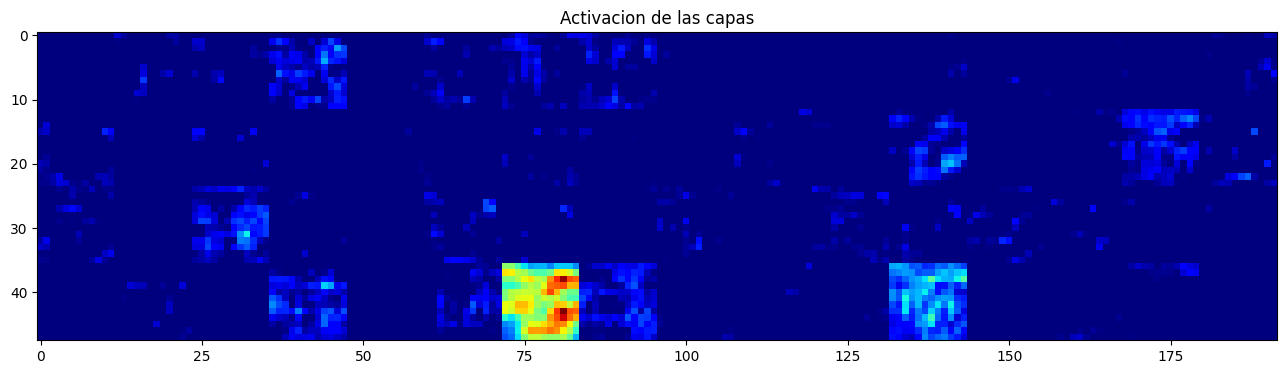

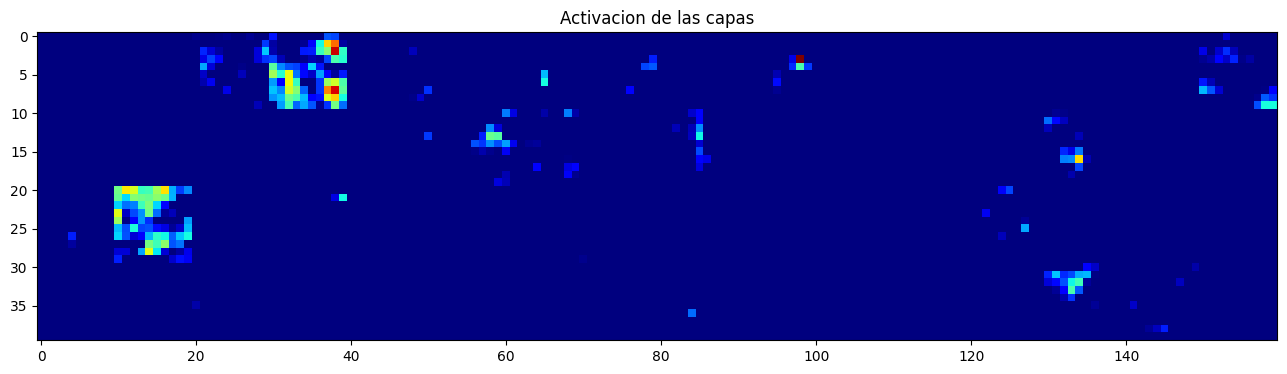

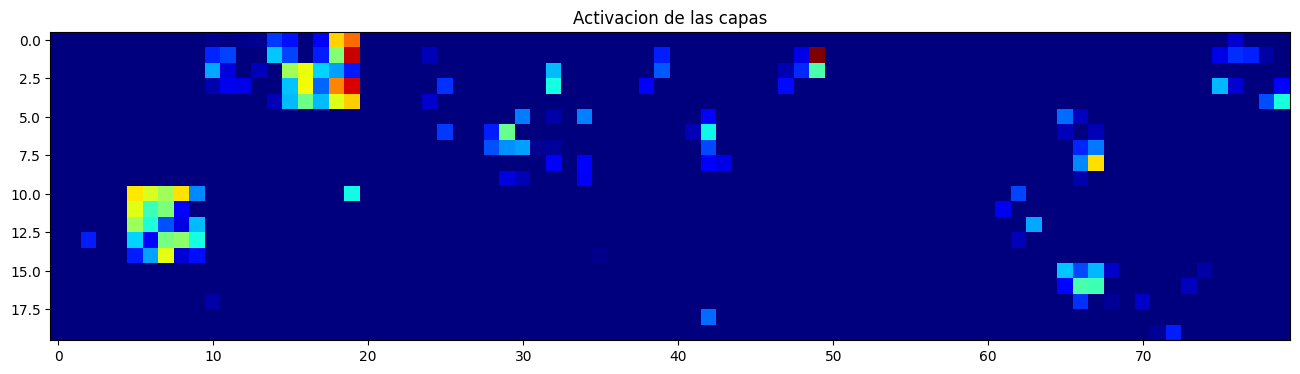

In [28]:
import numpy as np
# Visualizar todas las capas
layer_names = [layer.name for layer in model_augmentation.layers[:7]]
images_per_row = 16
display_grid = []
for layer_name, layer_activation in zip(layer_names,activations):
    # Número de features
    n_features = layer_activation.shape[-1]
    # Tamaño de cada feature
    size = layer_activation.shape[1]
    # Número de columnas a mostrar
    n_cols = n_features // images_per_row

    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_img = layer_activation[0,:,:,col * images_per_row + row]
            display_grid[col * size : (col + 1) * size,
                        row * size : (row + 1) * size] = channel_img
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                       scale * display_grid.shape[0]))
    plt.title('Activacion de las capas')
    plt.grid(False)
    plt.imshow(display_grid,aspect='auto',cmap='jet')

### Interpretacion
- Capas iniciales son como detectores de bordes
- Capas más profundas son más difíciles de interpretar (abstractas) y tienen información relativa a la clase de imagen
- La activación de capas profundas es más dispersa (sparse)

#### **- Visualizar filtros convolucionales**

- Visualizar las imagenes que maximizan la respuesta a un filtro (deep dream)

In [38]:
from keras.applications import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet',include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Explicación:

- Nos quedamos con la entrada y los 2 primeros bloques.
- ¿Cuál es la entrada que lo maximiza?
    - Primeramente:
        - Entrada: (1, 224, 224, 3)
        - Salida: (1, 224, 224, 64)
    - Los pesos del modelo se actualizan de la siguiente forma (vamos haciendo steps en base al gadiente de la función de pérdidas respecto a los pesos):
        - Wt+1 = Wt + lr * dL/dW
    - Objetivo: maximizar activación en block1_conv2
        - Lfilter = - sum(block1_conv2(:,:,:,nfilter))
    - Asumimos que nuestra imagen de entrada la podemos parametrizar con un peso 'Winput' y congelamos todos los pesos intermedios (se dejan fijos los del block1_conv1)
    - Podemos optimizar la imagen de entrada para buscar el máximo
        - Winput+1 = Winput+ lr * Lfilter/Winput
    - Se itera hasta que se encuentra la imagen que maximiza la activación del filtro


In [39]:
import numpy as np
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

def gen_max_response_pattern(layer_name, filter_index, size=32):
    """
    Args:
        layer_name : str : nombre de la capa
        filter_index : int : índice del filtro
        size : int : tamaño del pseudomapa
    """
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Para obtener el patron que responde de forma máxima, utilizamos descenso del gradiente
    grads = K.gradients(loss,model.input)[0] # Seleccionar el primero, ya que esto devuelve una lista
    # Normalización para ayudar al proceso del gradiente
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # Última constante para evitar dividir por 0
    # Definir funcion que calcula la pérdida y el gradiente de la imagen
    iterate = K.function([model.input], [loss,grads])
    loss_value, grads_value = iterate([np.zeros((1,size,size,3))])

    # Iniciamos con imagen aleatoria
    input_img_data = np.random.random((1,size,size,3)) * 20 + 128

    step = 1. # Magnitud de cada actualizacion en el gradiente
    n_steps = 40 # Número de iteraciones
    for i in range(n_steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    # Procesar la imagen resultante
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.1
    img += 0.5
    img = np.clip(img,0,1)
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

[Keras Visualization Toolkit](https://github.com/raghakot/keras-vis)

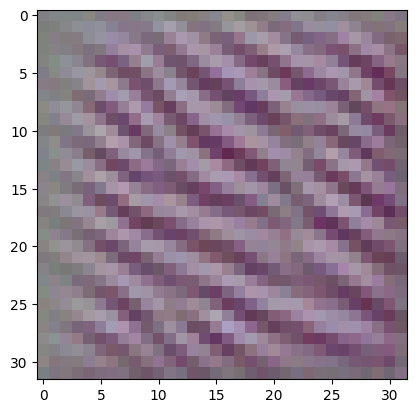

In [54]:
# mostrar un patron para un filtro
import matplotlib.pyplot as plt
%matplotlib inline

layer_name = 'block2_conv1'
# layer_name = 'block4_conv3'
filter_index = 112 # canal a estudiar
# filter_index = 32 # canal a estudiar

img = gen_max_response_pattern(layer_name,filter_index,32)
plt.imshow(img)

#### **- Visualizar hetmaps de activación por clase**

- Útil para averiguar qué partes de la imagen contribuyen más a la decisión
- Interesante para saber qué pasa cuando se cometen errores

In [55]:
# Técnica utiliza gradientes Ramprasaath, R. Selvaraju et al. (2017). https://arxiv.org/abs/1610.02391
from keras.applications import VGG16

model = VGG16(weights='imagenet',include_top=True)

553467096/553467096 [==============================] - 7s 0us/step


In [56]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# Cargar imagen de gato
img = image.load_img(BASE_FOLDER+'resources/cat.jpg', target_size=(224,224))
x = image.img_to_array(img) # a array de (224,224,3)
x = np.expand_dims(x, axis=0) # a array de (1,224,224,3)
x = preprocess_input(x)

In [57]:
# Testeando el output
prediction = model.predict(x)
print(decode_predictions(prediction))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


35363/35363 [==============================] - 0s 0us/step
[[('n02123045', 'tabby', 0.34906915), ('n02124075', 'Egyptian_cat', 0.3217116), ('n02123159', 'tiger_cat', 0.2860953), ('n02127052', 'lynx', 0.013805194), ('n04040759', 'radiator', 0.0009079651)]]


[IMAGENET 1000 Class List](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)

- 287	lynx, catamount
- 285	Egyptian cat

In [66]:
tabby_output_index = np.argmax(prediction[0]) # índice de la clase que tiene una mayor probabilidad
lynx = 287
egyptian = 285

# dentro del output nos quedamos con esa capa, esto sería el tensor de output
# dada la clase, igual que antes cogíamos un tensor que era una activación intermedia,
# ahora cogemos unos tensores de salida (de la clase)
tabby_output = model.output[:,tabby_output_index]
# tabby_output = model.output[:,egyptian]

# cogemos el mapa convolucional sobre el cuál queremos visualizar espacialmente
# las activaciones (se suele coger el último) y lo ponderamos
last_conv_layer = model.get_layer('block5_conv3')

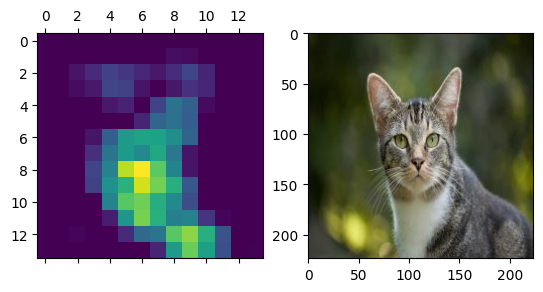

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K

# se pondera a través de los gradientes, si hay una zona que se activa más
# a esta se le da más importancia o menos
grads = K.gradients(tabby_output, last_conv_layer.output)[0]
# pooling a nivel de filtro, si tenemos N filtros en ese bloque, filtros más
# relevantes
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function( [model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

# Multiplicar cada canal en el feature map por como de importante el canal es con respecto a la clase "tabby"
for i in range(512):
    # cada salida la ponderamos
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

# promedio a nivel espacial de los N filtros
heatmap = np.mean(conv_layer_output_value, axis=-1)

# Visualizar (class activation maps)
heatmap = np.maximum(heatmap,0)
# acotamos entra 0 y 1
heatmap /= np.max(heatmap)
fig,axes = plt.subplots(1,2)
axes[0].matshow(heatmap)
axes[1].imshow(img)
plt.show()